In [32]:
%matplotlib widget
# %matplotlib inline
# %load_ext line_profiler
import numpy as np
import time
import seaborn as sns
import pandas as pd
from scipy import spatial, stats
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nrrd
import multiprocessing as mp
# from pathos.multiprocessing import ProcessingPool as Pool
import raster_geometry as rg
import sys
import os
# from dotenv import load_dotenv

sys.path.append("C:\\Users\\danie\\BoneSegmentation")

from oiffile import OifFile
# from spacer3d.OifImageViewer import OifImageViewer
from spacer3d.Ripley import CrossRipley, load_OIB, load_mask, load_tumor_locations

Inputs:
    Image: 
    Mask: Shape should match image and point data (i.e. 3D mask for 3D image/points)
    Points_1: Points in list of shape (N, Z, Y, X) for 3D and (N, Y, X) for 2D
    Points_2: ...
    ...

[[  75. 1417. 2404.]
 [  75. 1413. 2395.]
 [  75. 1380. 2377.]
 [  75. 1352. 2479.]
 [  75. 1080. 2266.]
 [  75.  989.  730.]]

In [33]:
### Loading Confocal Image (.OIB)

# path = "/data/dkermany_data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20190619_111005.oib"
# path = "/data/dkermany_data/Bone_Project/weijie_selected/main_folder/FV10__oibs/tmp/FV10__20181004_122358.oib"
path = "/data/dkermany_data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20190620_111343.oib"
# path = "D:\\Datasets\\Bone_Mets\\FV10__oibs\\FV10__20190620_111343.oib"

filename, viewer, steps = load_OIB(path)


In [34]:
# def load_mask(path):
#     # Load mask from NRRD
#     mask, header = nrrd.read(path)
#     mask = mask.T
#     #mask = mask[:mask.shape[0]//3, :, :] # for FV10__20190620_111343.seg.nrrd
    
#     print(mask.shape)
#     print(mask.dtype)
#     print("Axes: ZYX")

#     return mask

In [35]:
### Loading 3D Binary Mask (.SEG.NRRD)

mask_path = f"/data/dkermany_data/Bone_Project/masks/{filename}.seg.nrrd"

mask = load_mask(mask_path)


(228, 2404, 3376)
uint8
Axes: ZYX


In [36]:
# def load_tumor_locations(path, filename, steps):
#     """
#     Load tumor locations from a CSV file, filter rows with missing values, and convert them to a 3D numpy array.

#     Parameters:
#     path (str): The file path to the CSV file containing tumor data.
#     filename (str): The name of the file to filter tumor data by.
#     steps (tuple): A tuple containing three values (x_step, y_step, z_step) for converting tumor locations from micrometers to steps.

#     Returns:
#     numpy.ndarray: A 3D numpy array containing the tumor locations in steps.
    
#     This function reads a CSV file at the specified path, drops rows with missing values, and filters the data by the given filename.
#     It then converts the x, y, and z coordinates from micrometers to steps using the provided steps tuple and stores them in a 3D numpy array.
#     The resulting numpy array contains the tumor locations in steps and is returned as the output of the function.
#     """
#     # Load CSV data and drop rows with missing values (N/A's)
#     tumor_csv = pd.read_csv(path).dropna()
    
#     # Filter rows in the CSV where the 'Filename' column matches the given 'filename'
#     # Reset the index of the filtered DataFrame
#     tumor_csv = tumor_csv[tumor_csv.Filename == filename].reset_index(drop=True)
    
#     # Extract individual step values for x, y, and z
#     x_step, y_step, z_step = steps

#     # Convert the filtered CSV data into a dictionary where each row is an entry
#     tumor_dict = tumor_csv.to_dict("index")
    
#     # Initialize an empty list to store tumor location points
#     tumor_points = []
    
#     # Iterate through the tumor information entries in the dictionary
#     for idx, tumor_info in tumor_dict.items():
#         # Extract x (um), y (um), and z (slice) values and convert them to integers
#         x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
        
#         # Calculate the corresponding x, y, and z coordinates based on step values
#         x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice - 1))
        
#         # Append the calculated coordinates as a list to the tumor_points list
#         # in (Z, Y, X) format
#         tumor_points.append([z, y, x])
    
#     # Convert the list of tumor location points to a NumPy array with dtype float64
#     tumor_points = np.array(tumor_points, dtype=np.float64)

#     # Return the NumPy array containing tumor location points
#     return tumor_points

In [37]:
### Loading Tumor Cell Locations (.CSV)
tumor_csv_path = "/data/dkermany_data/Bone_Project/tumor_locations_02_08_2023.csv"

tumor_points = load_tumor_locations(tumor_csv_path, filename, steps)

# tumor_csv

In [38]:
print(tumor_points)
print(tumor_points.shape)

[[  75. 1417. 2404.]
 [  75. 1413. 2395.]
 [  75. 1380. 2377.]
 [  75. 1352. 2479.]
 [  75. 1080. 2266.]
 [  75.  989.  730.]
 [  75.  704. 2427.]
 [  75.  693. 2432.]
 [  75.  732. 2459.]
 [  75.  840. 2633.]
 [  75.  600. 2675.]
 [  75.  595. 2771.]
 [  66. 1432. 2315.]
 [  64.  710. 2384.]
 [  62.  721. 2351.]
 [  61.  747. 2518.]
 [  59. 1119. 2344.]
 [  58. 1399. 2301.]
 [  53.  647. 1892.]
 [  53.  647. 1892.]
 [  51. 1417. 2336.]
 [  51. 1423. 2351.]
 [  48.  592. 2799.]
 [  43. 1393. 2367.]
 [  42.  685. 1942.]
 [  36. 1130. 2411.]
 [  35.  668. 1928.]
 [  26. 1294. 2030.]
 [  26. 1243. 1731.]
 [  13.  752.  823.]
 [   4. 1226. 1690.]
 [   0. 1351. 2243.]
 [   0. 1356. 2159.]
 [   0. 1338. 2159.]
 [   0. 1475. 2531.]]
(35, 3)


In [39]:
def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Args:
    point1 (array-like): An array-like object representing the first point.
    point2 (array-like): An array-like object representing the second point.

    Returns:
    float: The Euclidean distance between the two points.
    """
    # Use NumPy's linalg.norm function to calculate the Euclidean distance
    return np.linalg.norm(point1-point2)

def micron_to_pixel(micron, scale_factor):
    pass

# Test distance function
print(euclidean_distance(np.array((10,10,10)),np.array((0,0,0))))

17.320508075688775


In [40]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

Draw sphere in a given volume
<a id='draw_sphere_in_volume'></a><br>
[Go to tumor function call](#tumor_ripley)

In [41]:
# def get_sphere_mask_intersection(mask: np.ndarray, radius: int, position: tuple) -> None:
#     """
#     Draw a sphere in a given 3D NumPy array at a specified position.

#     Args:
#     mask (numpy.ndarray): The 3D NumPy array in which the sphere will be drawn.
#     radius (int): The radius of the sphere.
#     position (tuple): A 3-tuple containing the z, y, x coordinates of the position in the array where the sphere will be drawn.

#     Returns:
#     None
#     """
    
#     # Create an empty 3D NumPy array with dimensions equal to twice the radius plus one
#     size = 2 * (radius + 1)

#     # Calculate the midpoint of the sphere unit array
#     midpoint = [size / 2] * 3

#     # Generate a unit sphere using the rg library's superellipsoid function
#     sphere = rg.nd_superellipsoid(size, radius, position=midpoint,
#                                   rel_sizes=False, rel_position=False).astype(np.int_)

#     # Extract the z, y, x coordinates of the position where the sphere will be drawn
#     z, y, x = map(round, position)

#     # Calculate the delta change needed to center the sphere at the specified position
#     d = (size//2)

#     # Calculate the minimum and maximum indices for the z, y, x axes of the mask array
#     # print(position, radius, x-d, x+d, max(x - d, 0), min(x + d, mask.shape[2]))
#     zmin, zmax = max(z - d, 0), min(z + d, mask.shape[0])
#     ymin, ymax = max(y - d, 0), min(y + d, mask.shape[1])
#     xmin, xmax = max(x - d, 0), min(x + d, mask.shape[2])

#     # Calculate the minimum indices for the z, y, x axes of the sphere array
#     szmin = abs(z - d) if z - d < 0 else 0
#     symin = abs(y - d) if y - d < 0 else 0
#     sxmin = abs(x - d) if x - d < 0 else 0

#     # Calculate the amount to cut off of the ends of the z, y, x axes of the sphere array
#     szmax = abs(mask.shape[0] - (z + d)) if z + d > mask.shape[0] else 0
#     symax = abs(mask.shape[1] - (y + d)) if y + d > mask.shape[1] else 0
#     sxmax = abs(mask.shape[2] - (x + d)) if x + d > mask.shape[2] else 0
#     # assert x+d < mask.shape[2]
    
#     # Trim the sphere array to fit within the trimmed mask array
#     sphere = sphere[szmin:sphere.shape[0]-szmax, symin:sphere.shape[1]-symax, sxmin:sphere.shape[2]-sxmax]
#     # Place the sphere within the larger mask array at the specified position

#     # Return intersection between mask subset and sphere
#     return mask[zmin:zmax, ymin:ymax, xmin:xmax] & sphere

In [42]:
# # Test speed
# %time rg.nd_superellipsoid(2*80+1, 80, position=[40,40,40], rel_sizes=False, rel_position=False).astype(np.int_)
# %time i = cle.draw_sphere(test_vol, 320, 640, 20, 80, 80, 80, 1)
# %lprun -f draw_sphere_in_volume draw_sphere_in_volume(test_vol, 50, position=[50,50,50])
# %timeit draw_sphere_in_volume(mask, 50, position=[50,50,50])
# plt.figure()
# cle.imshow(i)

In [43]:
# ### Test draw sphere function
# import pyclesperanto_prototype as cle

# test_vol = np.zeros(mask.shape, dtype=np.uint8)
# draw_sphere_in_volume(test_vol, 80, (20, 640, 320))
# print(test_vol.dtype, mask.dtype)

# plt.figure()
# cle.imshow(test_vol)
# plt.figure()
# cle.imshow(mask)
# plt.figure()
# cle.imshow(test_vol & mask)


<!-- Ripley's K Estimators

![RipleyK](/img/ripleyK.png)

![RipleyL](/img/ripleyL.png)

![RipleyH](/img/ripleyH.png) -->

In [44]:
# cache = {}

In [45]:
# ### Ripley Class 

# class Ripley():
#     """
#     Ripley Class for spatial point pattern analysis.
#     """
#     def __init__(
#             self,
#             points_i: np.ndarray,
#             radii: list,
#             mask: np.ndarray,
#             boundary_correction: bool = True,
#             disable_progress: bool = True,
#     ):
#         """
#         Initialize a Ripley object.

#         Args:
#         points_i (np.ndarray): A 2D NumPy array of shape (N, 3) representing the coordinates of N points in 3D space.
#         radii (list): A list of radii at which to calculate Ripley's K, L, and H functions.
#         mask (np.ndarray): A 3D binary mask representing the study volume.
#         boundary_correction (bool, optional): Whether to apply boundary correction. Defaults to True.
#         disable_progress (bool, optional): Whether to disable progress bar. Defaults to True.
#         """
#         self.points_i = points_i
#         self.radii = radii
#         self.mask = mask.astype(np.uint8)
#         self.volume_shape = self.mask.shape
#         self.boundary_correction = boundary_correction
#         self.disable_progress = disable_progress
#         self._validate_inputs()

#         self.i_tree = spatial.cKDTree(self.points_i)
#         self.study_volume = reduce(lambda x, y: x * y, self.volume_shape)

#     @staticmethod
#     def worker(fn, task_queue, result_queue):
#         while True:
#             task = task_queue.get()
#             if task is None:  # 'None' is the signal to stop.
#                 break
#             index, radius = task
#             result = fn(radius)
#             result_queue.put((index, result))

#     def run(self, n_processes=32):
#         """
#         Run Ripley's analysis for the specified radii.

#         Args:
#         n_processes (int, optional): Number of processes to use for parallel computation. Defaults to 32.

#         Returns:
#         tuple: A tuple containing lists of K, L, and H values for each radius.
#         ""### Ripley Class 

# class Ripley():
#     """
#     Ripley Class for spatial point pattern analysis.
#     """
#     def __init__(
#             self,
#             points_i: np.ndarray,
#             radii: list,
#             mask: np.ndarray,
#             boundary_correction: bool = True,
#             disable_progress: bool = True,
#     ):
#         """
#         Initialize a Ripley object.

#         Args:
#         points_i (np.ndarray): A 2D NumPy array of shape (N, 3) representing the coordinates of N points in 3D space.
#         radii (list): A list of radii at which to calculate Ripley's K, L, and H functions.
#         mask (np.ndarray): A 3D binary mask representing the study volume.
#         boundary_correction (bool, optional): Whether to apply boundary correction. Defaults to True.
#         disable_progress (bool, optional): Whether to disable progress bar. Defaults to True.
#         """
#         self.points_i = points_i
#         self.radii = radii
#         self.mask = mask.astype(np.uint8)
#         self.volume_shape = self.mask.shape
#         self.boundary_correction = boundary_correction
#         self.disable_progress = disable_progress
#         self._validate_inputs()

#         self.i_tree = spatial.cKDTree(self.points_i)
#         self.study_volume = reduce(lambda x, y: x * y, self.volume_shape)

#     @staticmethod
#     def worker(fn, task_queue, result_queue):
#         while True:
#             task = task_queue.get()
#             if task is None:  # 'None' is the signal to stop.
#                 break
#             index, radius = task
#             result = fn(radius)
#             result_queue.put((index, result))

#     def run(self, n_processes=32):
#         """
#         Run Ripley's analysis for the specified radii.

#         Args:
#         n_processes (int, optional): Number of processes to use for parallel computation. Defaults to 32.

#         Returns:
#         tuple: A tuple containing lists of K, L, and H values for each radius.
#         """
#         task_queue = mp.Queue()
#         result_queue = mp.Queue()

#         # Start worker processes
#         processes = [mp.Process(target=self.worker, args=(self._calc_ripley, task_queue, result_queue))
#                      for _ in range(n_processes)]
#         for p in processes:
#             p.start()

#         # Distribute tasks
#         for index, input_data in enumerate(self.radii):
#             task_queue.put((index, input_data))

#         # Signal the end of tasks
#         for _ in processes:
#             task_queue.put(None)

#         # Collect results
#         results = [None] * len(self.radii)
#         for _ in range(len(self.radii)):
#             index, result = result_queue.get()
#             results[index] = result

#         # Wait for all worker processes to finish
#         for p in processes:
#             p.join()

#         K, L, H, metrics = zip(*results)
#         flattened_metrics = [i for s in metrics for i in s]
        
#         return K, L, H, flattened_metrics

#     def calculate_weight(self, radius, center):
#         """
#         Calculate the proportion of a sphere within a study volume.

#         Args:
#         radius (int): The radius of the sphere.
#         center (tuple): A 3-tuple containing the z, y, x coordinates of the center of the sphere.

#         Returns:
#         float: The proportion of the sphere within the study volume.
#         """
#         # Ensure that the radius is greater than zero
#         assert radius > 0

#         # Check if cached weight for this coordinate exists
#         key = center + (radius,)
#         if key in cache:
#             return cache[key]
        
#         # Draw the target sphere in a 3D NumPy array at the specified position
#         # target = np.zeros(self.volume_shape, dtype=np.uint8)
#         # draw_sphere_in_volume(target, radius, center)

#         # Bitwise and operation between the sphere and mask to calculate intersection
#         # target = target & self.mask
#         intersection = get_sphere_mask_intersection(self.mask, radius, center)

#         # Calculate the sum (volume) of the target and reference sphere arrays
#         intersection_vol = intersection.sum()

#         # Reference is calculated instead of simulated for speed increase
#         reference = (4 / 3) * np.pi * (radius ** 3)

#         # Ensure that the reference sphere has a non-zero volume
#         assert reference > 0

#         # Return the proportion of the sphere within the study volume
#         # Since target volume is estimated whereas reference volume is calculated,
#         # there is a small but noticable margin of error when radius < 10, there
#         # we set maxiumum value of 1.0
#         weight = min(intersection_vol / reference, 1.0)

#         # Save weight to cache
#         cache[key] = weight
        
#         return weight

#     @staticmethod
#     def plot_performance(run_times):
#         plt.figure(figsize=(5,5))
#         df = pd.DataFrame(run_times, columns=["radius", "time", "type"])
#         sns.lineplot(data=df, x="radius", y="time", hue="type")
#         plt.show()

#     def _validate_inputs(self):
#         """Validate the input parameters to ensure they meet the required criteria.

#         Raises:
#         ValueError: If any of the input parameters do not meet the required criteria.
#         """                # pool.map(self._calc_ripley, self.radii)
#         # Check if self.points_i is a list or numpy array
#         if not isinstance(self.points_i, (list, np.ndarray)):
#             e = f"Expected {np.ndarray}, received {type(self.points_i)}"
#             raise ValueError(e)

#         # Convert self.points_i to numpy array if it is a list
#         if not isinstance(self.points_i, np.ndarray):
#             self.points_i = np.array(self.points_i)

#         # Check if self.points_i array has two dimensions
#         if len(self.points_i.shape) != 2:
#             e = f"Expected self.points_i array to have 2 dimensions, but got array with shape {self.points_i.shape}"
#             raise ValueError(e)

#         # Check if the self.points_i array second dimension length is 3 (x, y, z)
#         if self.points_i.shape[1] != 3:
#             e = f"Expected self.points_i array to have shape (None, 3), but got array with shape {self.points_i.shape}"
#             raise ValueError(e)

#         # Check if the self.points_i array has at least 3 points
#         if self.points_i.shape[0] < 3:
#             e = f"Expected self.points_i array to have at least 3 points"
#             raise ValueError(e)

#         # Check if radii is list-like or number-like
#         if not isinstance(self.radii, (np.ndarray, list, int, float)):
#             e = f"Expected {(np.ndarray, list, int, float)}, received {type(self.radii)}"
#             raise ValueError(e)

#         # if only one radius given as int, convert to list
#         if not isinstance(self.radii, (np.ndarray, list)):
#             self.radii = [self.radii]"
#         task_queue = mp.Queue()
#         result_queue = mp.Queue()

#         # Start worker processes
#         processes = [mp.Process(target=self.worker, args=(self._calc_ripley, task_queue, result_queue))
#                      for _ in range(n_processes)]
#         for p in processes:
#             p.start()

#         # Distribute tasks
#         for index, input_data in enumerate(self.radii):
#             task_queue.put((index, input_data))

#         # Signal the end of tasks
#         for _ in processes:
#             task_queue.put(None)

#         # Collect results
#         results = [None] * len(self.radii)
#         for _ in range(len(self.radii)):
#             index, result = result_queue.get()
#             results[index] = result

#         # Wait for all worker processes to finish
#         for p in processes:
#             p.join()

#         K, L, H, metrics = zip(*results)
#         flattened_metrics = [i for s in metrics for i in s]
        
#         return K, L, H, flattened_metrics

#     def calculate_weight(self, radius, center):
#         """
#         Calculate the proportion of a sphere within a study volume.

#         Args:
#         radius (int): The radius of the sphere.
#         center (tuple): A 3-tuple containing the z, y, x coordinates of the center of the sphere.

#         Returns:
#         float: The proportion of the sphere within the study volume.
#         """
#         # Ensure that the radius is greater than zero
#         assert radius > 0

#         # Check if cached weight for this coordinate exists
#         key = center + (radius,)
#         if key in cache:
#             return cache[key]
        
#         # Draw the target sphere in a 3D NumPy array at the specified position
#         # target = np.zeros(self.volume_shape, dtype=np.uint8)
#         # draw_sphere_in_volume(target, radius, center)

#         # Bitwise and operation between the sphere and mask to calculate intersection
#         # target = target & self.mask
#         intersection = get_sphere_mask_intersection(self.mask, radius, center)

#         # Calculate the sum (volume) of the target and reference sphere arrays
#         intersection_vol = intersection.sum()

#         # Reference is calculated instead of simulated for speed increase
#         reference = (4 / 3) * np.pi * (radius ** 3)

#         # Ensure that the reference sphere has a non-zero volume
#         assert reference > 0

#         # Return the proportion of the sphere within the study volume
#         # Since target volume is estimated whereas reference volume is calculated,
#         # there is a small but noticable margin of error when radius < 10, there
#         # we set maxiumum value of 1.0
#         weight = min(intersection_vol / reference, 1.0)

#         # Save weight to cache
#         cache[key] = weight
        
#         return weight

#     @staticmethod
#     def plot_performance(run_times):
#         plt.figure(figsize=(5,5))
#         df = pd.DataFrame(run_times, columns=["radius", "time", "type"])
#         sns.lineplot(data=df, x="radius", y="time", hue="type")
#         plt.show()

#     def _validate_inputs(self):
#         """Validate the input parameters to ensure they meet the required criteria.

#         Raises:
#         ValueError: If any of the input parameters do not meet the required criteria.
#         """                # pool.map(self._calc_ripley, self.radii)
#         # Check if self.points_i is a list or numpy array
#         if not isinstance(self.points_i, (list, np.ndarray)):
#             e = f"Expected {np.ndarray}, received {type(self.points_i)}"
#             raise ValueError(e)

#         # Convert self.points_i to numpy array if it is a list
#         if not isinstance(self.points_i, np.ndarray):
#             self.points_i = np.array(self.points_i)

#         # Check if self.points_i array has two dimensions
#         if len(self.points_i.shape) != 2:
#             e = f"Expected self.points_i array to have 2 dimensions, but got array with shape {self.points_i.shape}"
#             raise ValueError(e)

#         # Check if the self.points_i array second dimension length is 3 (x, y, z)
#         if self.points_i.shape[1] != 3:
#             e = f"Expected self.points_i array to have shape (None, 3), but got array with shape {self.points_i.shape}"
#             raise ValueError(e)

#         # Check if the self.points_i array has at least 3 points
#         if self.points_i.shape[0] < 3:
#             e = f"Expected self.points_i array to have at least 3 points"
#             raise ValueError(e)

#         # Check if radii is list-like or number-like
#         if not isinstance(self.radii, (np.ndarray, list, int, float)):
#             e = f"Expected {(np.ndarray, list, int, float)}, received {type(self.radii)}"
#             raise ValueError(e)

#         # if only one radius given as int, convert to list
#         if not isinstance(self.radii, (np.ndarray, list)):
#             self.radii = [self.radii]

In [46]:
# ### Multivariate Ripley Class

# class CrossRipley(Ripley):
#     """
#     CrossRipley Class for multivariate spatial point pattern analysis.
#     Inherits from Ripley class.
#     """

#     def __init__(
#             self,
#             points_i: np.ndarray,
#             points_j: np.ndarray,
#             radii: list,
#             mask: np.ndarray,
#             boundary_correction: bool = True,
#             disable_progress: bool = True,
#     ):
#         """
#         Initialize a CrossRipley object.

#         Args:
#         points_i (np.ndarray): A 2D NumPy array of shape (N, 3) representing the coordinates of points of type 'i' in 3D space.
#         points_j (np.ndarray): A 2D NumPy array of shape (M, 3) representing the coordinates of points of type 'j' in 3D space.
#         radii (list): A list of radii at which to calculate Ripley's K, L, and H functions.
#         mask (np.ndarray): A 3D binary mask representing the study volume.
#         boundary_correction (bool, optional): Whether to apply boundary correction. Defaults to True.
#         """
#         # Call the parent class's __init__ method using super()
#         super().__init__(
#             points_i=points_i,
#             radii=radii,
#             mask=mask,
#             boundary_correction=boundary_correction,
#             disable_progress=disable_progress,
#         )

#         # Assign points_j to the self.points_j attribute and validate
#         self.points_j = points_j
#         self._validate_cross_inputs()

#         # Create a new tree for points_j
#         self.j_tree = spatial.cKDTree(self.points_j)


#     def test_ripley(self):
#         self.results = {"K": [], "L": [], "H": []}
#         for r in tqdm(self.radii):
#             self._calc_ripley(r)
#         return list(self.results["K"]), list(self.results["L"]), list(self.results["H"])

#     # TODO: Rewrite univariate _calc_ripley function for multivariate case
#     def _calc_ripley(self, radius):
#         """
#         Calculate 3D multivariate Ripley's functions (K_ij, L_ij, H_ij) for a given radius and
#         and apply weight coefficient.

#         For each radius, loop through each point_i and count number of point_j within the radius.
#         If boundary_correction is True, calculate the weight coefficient based on the volume of
#         the search sphere within the study volume.

#         Args:

#             radius (float): the radius for which to calculate Ripley's functions.

#         Raises:
#             ValueError: if K/L values are negative.

#         Returns:
#             None. Results are stored in self.results.

#         """
#         # For each radius, loop through each point and count points
#         # within the radius
#         # print(f"radius = {radius}", flush=True)
#         nb_count = 0
#         running_weights = []
#         running_trees = []
#         for z, y, x in self.points_i:
#             start_time = time.time()

#             if self.boundary_correction:
#                 weight = self.calculate_weight(radius, (z, y, x))
#                 # If weight is zero (i.e. target sphere not in mask), move on
#                 if weight == 0:
#                     continue
#             else:
#                 weight = 1.0

#             end_time = time.time()
#             weight_time = end_time - start_time
#             running_weights.append(1000*weight_time)

#             # Since the i point is not included within the j_tree, we do not subtract 1
#             # as done in the univariate implementation
            
#             start_time = time.time()

#             nb_count += (len(self.j_tree.query_ball_point([z, y, x], radius, workers=-1))) / weight

#             end_time = time.time()
#             tree_time = end_time - start_time
#             running_trees.append(1000*tree_time)

#         # calculating 3D Ripley's functions (K_ij, L_ij, H_ij)
#         N_i = self.points_i.shape[0]
#         N_j = self.points_j.shape[0]
#         K_ij = nb_count * self.study_volume / (N_i * N_j)
#         L_ij = ((3. / 4) * (K_ij / np.pi)) ** (1. / 3)
#         H_ij = L_ij - radius
        
#         # Verify K/L values positive
#         if K_ij < 0 or L_ij < 0:
#             raise ValueError(f"K/L values should not be negative. nb_count: {nb_count}, volume: {self.volume_shape}, N_i: {N_i}, N_j: {N_j}")

#         return (
#             K_ij,
#             L_ij,
#             H_ij,
#             [(radius, sum(running_weights) / len(running_weights), "weights"),
#              (radius, sum(running_trees) / len(running_trees), "trees"),]
#         )

#     def _validate_cross_inputs(self):
#         # Check if self.points_j is a list or numpy array
#         if not isinstance(self.points_j, (list, np.ndarray)):
#             e = f"Expected {np.ndarray}, received {type(self.points_j)}"
#             raise ValueError(e)

#         # Convert self.points_j to numpy array if it is a list
#         if not isinstance(self.points_j, np.ndarray):
#             self.points_j = np.array(self.points_j)

#         # Check if self.points_j array has two dimensions
#         if len(self.points_j.shape) != 2:
#             e = f"Expected self.points_j array to have 2 dimensions, but got array with shape {self.points_j.shape}"
#             raise ValueError(e)

#         # Check if the self.points_j array second dimension length is 3 (x, y, z)
#         if self.points_j.shape[1] != 3:
#             e = f"Expected self.points_j array to have shape (None, 3), but got array with shape {self.points_j.shape}"
#             raise ValueError(e)

#         # Check if the self.points_j array has at least 3 points
#         if self.points_j.shape[0] < 3:
#             e = f"Expected self.points_j array to have at least 3 points"
#             raise ValueError(e)

#         # if only one radius given as int, convert to list
#         if not isinstance(self.radii, (np.ndarray, list)):
#             self.radii = [self.radii]

#         # if points are not within volume, raise error
#         for p in [self.points_j]:
#             assert all(x < self.volume_shape[2] for x in p[:, 2])
#             assert all(y < self.volume_shape[1] for y in p[:, 1])
#             assert all(z < self.volume_shape[0] for z in p[:, 0])

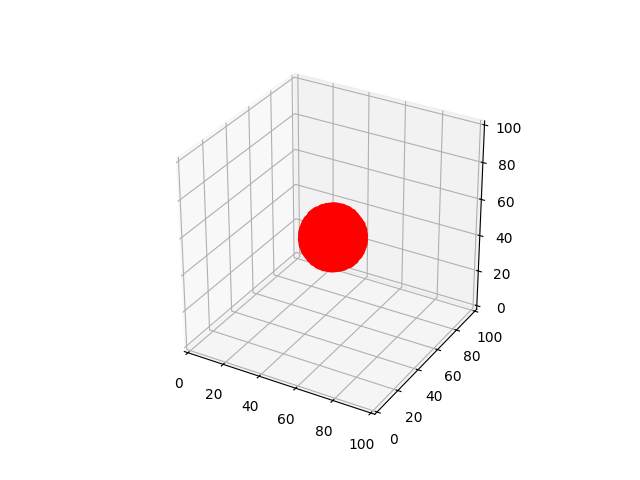

In [47]:
### Test sphere drawing

def draw_sphere(shape, radius, center) -> np.ndarray:
    sphere = rg.nd_superellipsoid(shape, radius, position=center, rel_sizes=False, rel_position=False)
    return sphere.astype(np.int_)

container_shape = (100, 100, 100)
radius = 15
center = (50, 50, 50)

# print(calculate_weight(container_shape, radius, center))
test_sphere = draw_sphere(container_shape, radius, center)

z,x,y = test_sphere.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
set_aspect_ratio_equal(ax)
ax.axes.set_xlim3d(left=0, right=container_shape[1]) 
ax.axes.set_ylim3d(bottom=0, top=container_shape[2]) 
ax.axes.set_zlim3d(bottom=0, top=container_shape[0]) 
ax.scatter(x, y, z, zdir='z', c= 'red')
plt.show()

In [48]:
def sample_clustered_points(points):
    from random import randrange
    """
    Given a set of points, returns a second set of points that are spatially
    related
    """
    new_points = [[z+randrange(0,11)-5, y+randrange(0,11)-5, x+randrange(0,11)-5] for z, y, x in points]
    return np.array(new_points)

In [67]:
### Visualize Multivariate Points Within Sphere
scale = 10

random_DTC = stats.uniform.rvs(loc=0, scale=100, size=(100,3))
# random_NG2 = sample_clustered_points(random_DTC)
random_NG2 = stats.uniform.rvs(loc=0, scale=100, size=(100,3))
# random_NG2 = stats.skewnorm.rvs(a=4, loc=50, scale=25, size=(100,3))

# DTC_tree = spatial.cKDTree(random_DTC)
NG2_tree = spatial.cKDTree(random_NG2)

# DTC_idx_in = DTC_tree.query_ball_point((50,50,50), scale)
NG2_idx_in = NG2_tree.query_ball_point((50,50,50), scale)

/tmp/ipykernel_17735/1373778876.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


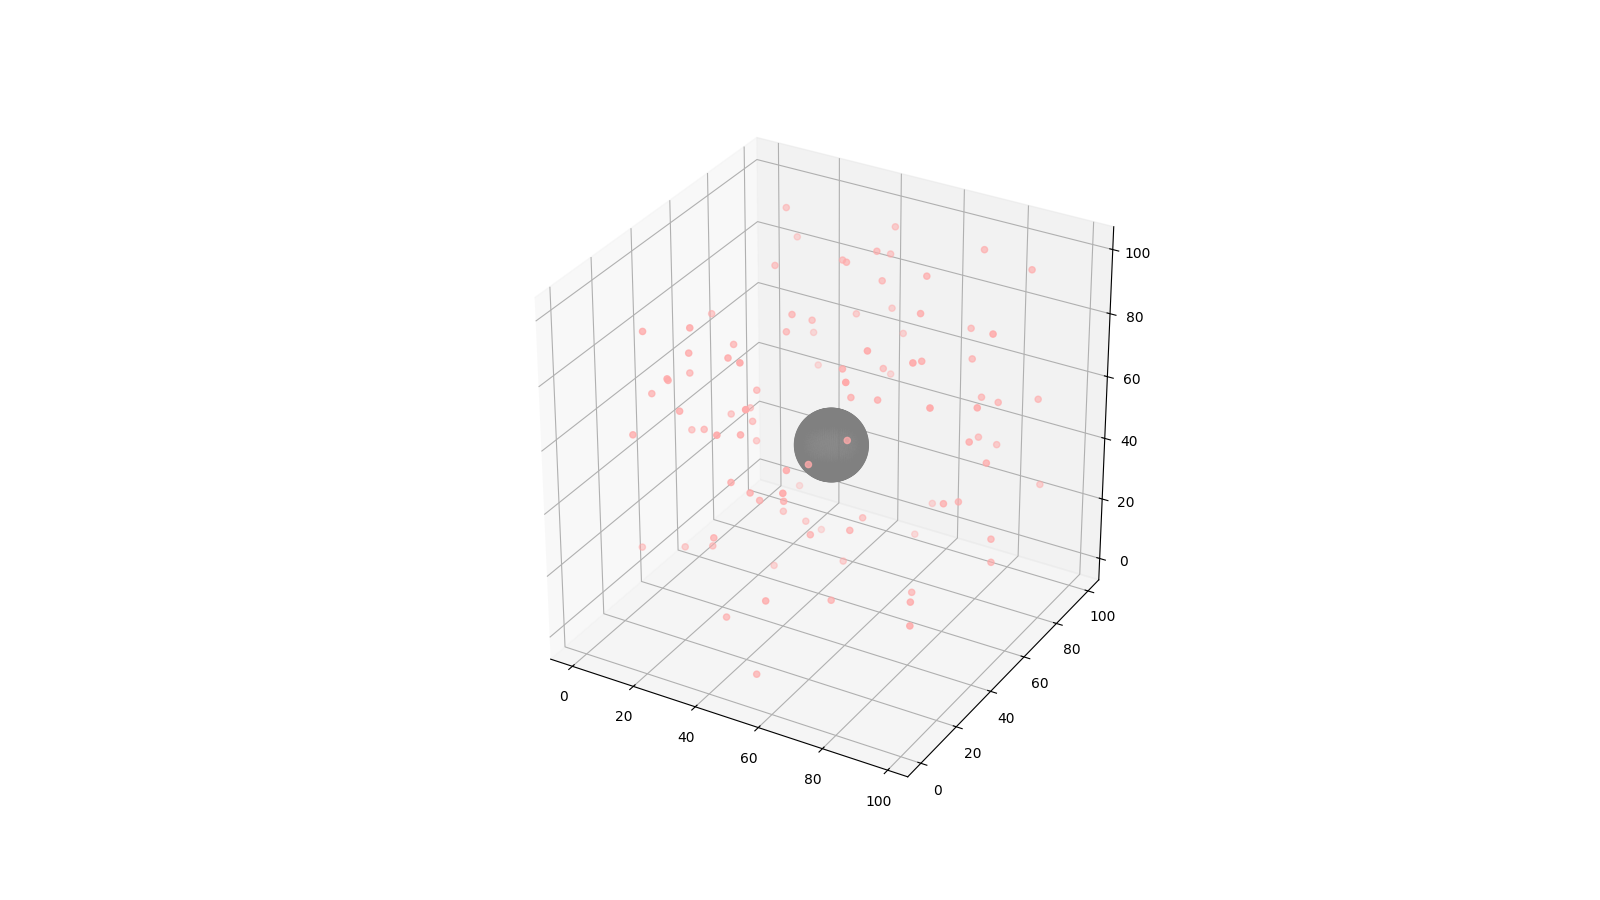

In [73]:
# DTC_idx_out = np.ones(len(random_DTC), bool); DTC_idx_out[DTC_idx_in] = 0
NG2_idx_out = np.ones(len(random_NG2), bool); NG2_idx_out[NG2_idx_in] = 0

# DTC_inside, DTC_outside = random_DTC[DTC_idx_in], random_DTC[DTC_idx_out]
NG2_inside, NG2_outside = random_NG2[NG2_idx_in], random_NG2[NG2_idx_out]

# DTC_ix, DTC_ox = DTC_inside[:, 0], DTC_outside[:, 0]
# DTC_iy, DTC_oy = DTC_inside[:, 1], DTC_outside[:, 1]
# DTC_iz, DTC_oz = DTC_inside[:, 2], DTC_outside[:, 2]

NG2_ix, NG2_ox = NG2_inside[:, 0], NG2_outside[:, 0]
NG2_iy, NG2_oy = NG2_inside[:, 1], NG2_outside[:, 1]
NG2_iz, NG2_oz = NG2_inside[:, 2], NG2_outside[:, 2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
set_aspect_ratio_equal(ax)
# ax.scatter(DTC_ix,DTC_iy,DTC_iz, color="orange",marker="o", depthshade=0)
# ax.scatter(DTC_ox,DTC_oy,DTC_oz,color="gold",marker="o", depthshade=1)
# ax.scatter(NG2_ix,NG2_iy,NG2_iz, color="blue",marker="o", depthshade=0)
# ax.scatter(NG2_ox,NG2_oy,NG2_oz,color="skyblue",marker="o", depthshade=1)
# ax.scatter(DTC_ix,DTC_iy,DTC_iz, color="green",marker="o", depthshade=0)
# ax.scatter(DTC_ox,DTC_oy,DTC_oz,color="green",marker="o", depthshade=1)
ax.scatter(NG2_ix,NG2_iy,NG2_iz, color="#f00",marker="o", depthshade=True)
ax.scatter(NG2_ox,NG2_oy,NG2_oz,color="#ffaaaa",marker="o", depthshade=True)

# draw sphere
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
cx = scale*np.cos(u)*np.sin(v)+50
cy = scale*np.sin(u)*np.sin(v)+50
cz = scale*np.cos(v)+50
# ax.plot_wireframe(cx, cy, cz, color="gray", alpha=0.3)
# ax.scatter(50, 50, 50, color="green", marker="o", s=50, depthshade=True)
ax.scatter(cx, cy, cz, color="gray", s=1, alpha=0.3)

In [51]:
# For this rectangular test case, volume_mask is just an array of ones

volume_mask = np.ones((100,100,100))
# volume = volume_mask.sum()
# volume_shape = volume_mask.shape

In [54]:
### Run Multivariate (Cross) Ripley on Random Points data
crossripley_data = []
crossripley_data_w = []

radii = np.arange(2, 67) 
crossripley = CrossRipley(random_DTC, random_NG2, radii, volume_mask, boundary_correction=False)
crossripley_w = CrossRipley(random_DTC, random_NG2, radii, volume_mask, boundary_correction=True)

K, L, H, _ = map(sorted, crossripley.run(1))
# Sort by radii
# print(L)

K_w, L_w, H_w, _ = map(sorted, crossripley_w.run(16))
# %lprun -f crossripley_w.calculate_weight map(sorted, crossripley_w.run(1))
# %timeit map(sorted, crossripley_w.run(1))

# Organize into list of [Radius, K, L, H] 
crossripley_data += [(r, k, l, h) for r, k, l, h in zip(radii, K, L, H)]
crossripley_data_w += [(r, k, l, h) for r, k, l, h in zip(radii, K_w, L_w, H_w)]

rstats = pd.DataFrame(crossripley_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)"])
rstats_w = pd.DataFrame(crossripley_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)"])

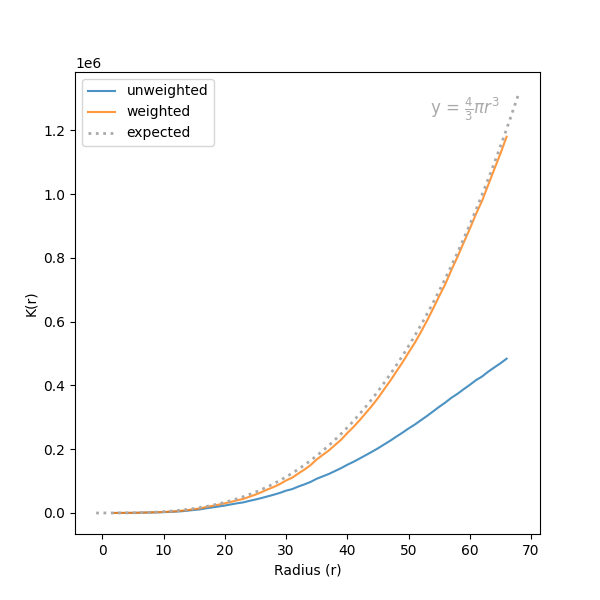

In [55]:
# Plot Random Points Results
plt.rcParams['figure.figsize'] = [16, 9]
plt.figure(figsize=(6,6))

# Unweighted K function
sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", alpha=0.8, color=sns.color_palette()[0], label="unweighted")

# Weighted K function
sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", alpha=0.8, color=sns.color_palette()[1], label="weighted")

max_radius = 68

# Expected K function
r = np.linspace(-1, max_radius, 500)
vol_equation = (4/3) * np.pi * r**3
expected_df = pd.DataFrame({
    "radius": r,
    "expected": vol_equation,
})
sns.lineplot(data=expected_df, x="radius", y="expected", linewidth=2, linestyle="dotted", color="#aaa", label="expected")
plt.text(max_radius-3, 4/3 * np.pi * (max_radius-1)**3 - 10000, r'y = $\frac{4}{3}\pi r^3$', fontsize=12, horizontalalignment='right', color="#aaa")

plt.show()

In [75]:
from matplotlib.animation import FuncAnimation

# Set up the figure and subplots
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
set_aspect_ratio_equal(ax1)
ax2 = fig.add_subplot(122)

# Initial settings for the 3D scatter plot
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)
ax1.set_zlim(0, 100)
ax1.set_title('3D Scatter Plot')
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')
# ax1.view_init(azim=5)

# Example of adding a semi-transparent plane at z=0
# x_plane, y_plane = np.meshgrid(np.linspace(0, 100, 2), np.linspace(0, 100, 2))
# z_plane = np.zeros_like(x_plane)
# ax.plot_surface(x_plane, y_plane, z_plane, color='gray', alpha=0.9)

# Plot a point at (50, 50, 50) with size 1 initially
point, = ax1.plot([50], [50], [50], 'o', markersize=1, color='blue')

# Initial settings for the 2D line plot
ax2.set_xlim(0, max_radius+2)
ax2.set_ylim(0, max(vol_equation))
ax2.set_title('Volume of a Sphere as a Function of Radius')
ax2.set_xlabel('Radius (r)')
ax2.set_ylabel('Volume')
line, = ax2.plot([], [], color='green')
ax2.grid(True)

# Generate random points
random_NG2 = stats.uniform.rvs(loc=0, scale=100, size=(100, 3))
NG2_tree = spatial.cKDTree(random_NG2)

# Function to draw the wireframe sphere
def draw_sphere(ax, scale):
    u, v = np.mgrid[0:2*np.pi:110j, 0:np.pi:110j]
    cx = scale*np.cos(u)*np.sin(v) + 50
    cy = scale*np.sin(u)*np.sin(v) + 50
    cz = scale*np.cos(v) + 50
    # ax.plot_wireframe(cx, cy, cz, color="green", alpha=0.3)\

    cx_flat, cy_flat, cz_flat = cx.flatten(), cy.flatten(), cz.flatten()

    # Determine which points are inside the 100x100x100 volume
    inside_condition = (cx_flat >= 0) & (cx_flat <= 100) & \
                       (cy_flat >= 0) & (cy_flat <= 100) & \
                       (cz_flat >= 0) & (cz_flat <= 100)

    colors = np.where(inside_condition, "gray", "red")
    # alpha = np.where(inside_condition, 0.3, 0.1)
    ax.scatter(cx, cy, cz, color=colors, s=1, alpha=0.3)

# Initialize the line data
line_data = ([], [])

# Update function for the animation
def update(frame):
    ax1.clear()
    ax1.view_init(azim=frame/10 + 45, elev=10)
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0, 100)
    ax1.set_zlim(0, 100)
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Z axis')
    ax1.set_title('3D Wireframe Sphere')
    
    # Update the wireframe sphere with the new scale
    # scaling_factor = max_radius / len(r)
    draw_sphere(ax1, frame / 5 + 1)  # Scale grows over time

    # Determine inside and outside points
    NG2_idx_in = NG2_tree.query_ball_point((50, 50, 50), frame / 5)
    NG2_idx_out = np.ones(len(random_NG2), bool)
    NG2_idx_out[NG2_idx_in] = False
    NG2_inside, NG2_outside = random_NG2[NG2_idx_in], random_NG2[NG2_idx_out]
    
    # Plot points
    ax1.scatter(NG2_inside[:, 0], NG2_inside[:, 1], NG2_inside[:, 2], color="#f00", marker="o", depthshade=True)
    ax1.scatter(NG2_outside[:, 0], NG2_outside[:, 1], NG2_outside[:, 2], color="#ffaaaa", marker="o", depthshade=True)
    
    # Update the 2D line plot on the right to reveal the line up to the current frame
    if frame < len(r):
        line_data[0].append(r[int(frame)])
        line_data[1].append(vol_equation[int(frame)])
        line.set_data(line_data[0], line_data[1])
    
    return ax1, ax2

# Creating the animation with the updated logic
ani = FuncAnimation(fig, update, frames=len(r), blit=False, interval=50)

plt.close()  # Prevent displaying a static plot in the notebook

# ani  # Display the animation
ani.save('animation.mp4', writer='ffmpeg')

500


In [ ]:
## Visualize Univariate Points Within Sphere

test_radius = 60
test_center = (50, 50, 50)

test_random_points = stats.uniform.rvs(0, 100, (100,3))
test_tree = spatial.cKDTree(test_random_points)
idx_in = test_tree.query_ball_point(test_center, test_radius)

idx_out = np.ones(len(test_random_points), bool)
idx_out[idx_in] = 0

pts_inside_radius = test_random_points[idx_in]
pts_outside_radius = test_random_points[idx_out]

print(len(test_random_points), len(pts_inside_radius), len(pts_outside_radius))

ix, ox = pts_inside_radius[:, 0], pts_outside_radius[:, 0]
iy, oy = pts_inside_radius[:, 1], pts_outside_radius[:, 1]
iz, oz = pts_inside_radius[:, 2], pts_outside_radius[:, 2]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
set_aspect_ratio_equal(ax)
ax.scatter(ix,iy,iz, color="b",marker="o", depthshade=0)
ax.scatter(ox,oy,oz,color="r",marker="o", depthshade=1)

# Remove the grid
ax.grid(False)
# Optionally, remove the background pane as well
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Optionally, also remove the pane lines
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('gray')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
cx = test_radius*np.cos(u)*np.sin(v)+test_center[0]
cy = test_radius*np.sin(u)*np.sin(v)+test_center[1]
cz = test_radius*np.cos(v)+test_center[2]
ax.plot_wireframe(cx, cy, cz, color="gray", alpha=0.3)

ax.view_init(elev=30, azim=-135)
plt.savefig("/home/dkermany/Desktop/sphere_large_1.png", dpi=600)

### Complete Spatial Randomness (CSR) Representations

In [ ]:
CSR_data = []
CSR_data_w = []
# Starting at 2 because radius of 1 causes errors at the boundaries
# where sometimes the entire circle falls outside of study area
# resulting in a weight of 0.0
radii=np.arange(2, 67) 
volume_mask = np.ones((100, 310, 310))
n_samples = 5
for n in range(n_samples):
    print(f"{n}/{n_samples}")
    CSR_points = stats.uniform.rvs(0, 100, (100,3))
    # pbar = tqdm(total=len(CSR_points))
    ripley = CrossRipley(CSR_points, CSR_points, radii, volume_mask, boundary_correction=False)
    ripley_w = CrossRipley(CSR_points, CSR_points, radii, volume_mask, boundary_correction=True)

    # Sort by radii
    K, L, H, metrics = map(sorted, ripley.run(1))
    # print("done")
    K_w, L_w, H_w, metrics_w = map(sorted, ripley_w.run(16))

    # Organize into list of [Radius, K, L, H, Type, Line] 
    CSR_data += [(r, k, l, h, "CSR", n) for r, k, l, h in zip(radii, K, L, H)]
    CSR_data_w += [(r, k, l, h, "CSR", n) for r, k, l, h in zip(radii, K_w, L_w, H_w)]
    
rstats = pd.DataFrame(CSR_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
rstats_w = pd.DataFrame(CSR_data_w, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
rstats_w

In [ ]:
plt.rcParams['figure.figsize'] = [16, 9]
f, axes = plt.subplots(2, 3)

## Top Row
# K
sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0], hue="Line")
# L
sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0])
# L
sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1])
axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2])
axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()



In [ ]:
f, axes = plt.subplots(2, 3,)

## Top Row
# K
sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[0, 0adii,
        mask,], hue="L{"weights": [], "trees": []}ine")
# L
sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
sns.lineplot(data=rstats_w, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# L
sns.lineplot(data=rstats_w, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats_w, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()

In [ ]:
# import ipytest
# ipytest.autoconfig(raise_on_error=True)
# %%ipytest -qq

# # Tests

# def test_valid_input():
#     valid_points = [
#         np.array([[38.4002419, 38.62931512, 41.6131775], [38, 38, 41], [1, 6, 8]]),
#         np.array([[38, 38, 41], [1, 2, 3], [20, 20, 20]]),
#         [[38.4002419, 38.62931512, 41.6131775], [3.4002419, 8.62931512, 1.6131775], [8.4002419, 3.62931512, 4.6131775]],
#         [[38, 38, 41], [1, 2, 3], [4, 5, 6]],
#     ]
#     for p in valid_points:
#         ripley(p, radii=1, volume_shape=(100,100,100))

# def test_invalid_input():
#     invalid_points = [
#         np.array([[38.4002419, 38.62931512, 41.6131775]]),
#         np.array([[38, 38, 41], [1, 2, 3]]),
#         [[38.4002419, 38.62931512, 41.6131775]],
#         [[38, 38, 41], [1, 2, 3]],
#         "38.4002419, 38.62931512, 41.6131775",
#         np.array([38.4002419, 38.62931512, 41.6131775]),
#         np.array([[[38.4002419, 38.62931512, 41.6131775]]]),
#         np.array([[38.4002419, 38.62931512]]),
#         5,
#         7.8,
#         [6],
#     ]
#     for p in invalid_p{"weights": [], "trees": []}oints:
#         with pytest.raises(ValueError):
#             ripley(p, radii=1, volume_shape=(100,100,100))


In [ ]:
def run_ripley(
        points_i: np.ndarray,
        points_j: np.ndarray,
        mask: np.ndarray,
        radii: np.ndarray,
        boundary_correction: bool = True,
        n_processes: int = 32,
        n_line: int = None,
        disable_progress: bool = True):
    """
    Execute the Ripley's K-function analysis for two sets of points within a specified mask.

    This function computes Ripley's cross K-function, L-function, and H-function for two sets 
    of points. The analysis is based on a range of specified radii and can include boundary 
    correction. The results are sorted by radii and organized in a structured format.

    Parameters:
    points_i (list of tuples): The first set of points (e.g., (x, y) coordinates) for analysis.
    points_j (list of tuples): The second set of points for the cross K-function analysis.
    mask (array-like): A mask or region within which the analysis is conducted.
    radii (list): A list of radii values for which the K-function is computed.
    boundary_correction (bool, optional): Whether to apply boundary correction. Defaults to True.
    n_processes (int, optional): The number of processes to use for computation. Defaults to 1.
    n_line (int, optional): An additional parameter to include in the results, if provided.
    disable_progress (bool, optional): Set to False to disable tqdm progress bar for Ripley calculations

    Returns:
    list of tuples: Each tuple contains the radius, K-function value, L-function value, 
                    H-function value, and optionally the n_line value, sorted by radii.
    """
    # Initialize the CrossRipley object with the provided points, radii, mask, and boundary correction setting.
    # This object will be used to run Ripley's K-function analysis.
    ripley = CrossRipley(
        points_i,
        points_j,
        radii,
        mask,
        boundary_correction,
        disable_progress,
    )
    
    # Run the analysis using the specified number of processes and sort the results (K, L, H functions) by radii.
    # The map function applies the sorted function to each element (K, L, H) returned by ripley.run.
    # K_w, L_w, H_w, metrics = map(sorted, ripley.run(n_processes))
    K, L, H, metrics = ripley.run(n_processes)
    
    # Organize the results into a structured format for easy interpretation.
    # If n_line is specified, it is included in each tuple; otherwise, only K, L, and H values are included.
    # The comprehension iterates over zipped K, L, H tuples and constructs a result tuple for each set of values.
    results = [(r, k, l, h, n_line) if n_line else (r, k, l, h) 
               for k, l, h, r in zip(K, L, H, radii)]

    # print("Plot performance")
    ripley.plot_performance(metrics)

    # Return the organized list of tuples as the function's result.
    return results

In [ ]:
def monte_carlo(
        points_i,
        mask,
        radii,
        points_j=None,
        n_samples=5,
        boundary_correction=True,
        disable_progress=True,
        n_processes=32
):
    """
    Conducts a Monte Carlo simulation using the Ripley's K-function for spatial data analysis.

    This function can perform either univariate or bivariate spatial analysis based on the input points.
    It generates random points within a specified mask for univariate analysis or shuffles the
    labels of two point sets for bivariate analysis. The Ripley's K-function is computed over 
    a range of radii for these points.
    Parameters:
    - points_i (array-like): The first set of points for the analysis.
    - mask (array-like): A binary mask defining the study area, where 1 indicates valid area.
    - radii (array-like): An array of radii values to calculate Ripley
    - points_j (array-like, optional): The second set of points for bivariate analysis.
    - n_samples (int): The number of Monte Carlo samples to draw.
    - boundary_correction (bool): Whether to apply boundary correction.
    - disable_progress (bool): Whether to show the progress bars for Ripley's calculations
    - n_processes (int): Number of processes to use for parallel computation.

    Returns:
    - pd.DataFrame: A DataFrame containing the results of the Monte Carlo simulation.
    """
    
    def generate_random_points(points, mask):
        """
        Generate random points within the mask for univariate comparisons.

        This function creates a set of points that are randomly distributed within the valid
        areas defined by the mask. Each generated point must fall within the mask.

        Parameters:
        - points (array-like): The original set of points.
        - mask (array-like): The binary mask defining valid areas.

        Returns:
        - array-like: An array of randomly generated points within the mask.
        """
        CSR_points = np.empty((points.shape[0], 3), dtype=np.uint16)
        for i in range(points.shape[0]):
            while True:
                # Generate random point
                z, y, x = map(int, [stats.uniform.rvs(0, mask.shape[j]) for j in range(3)])
                if mask[z, y, x] == 1:
                    CSR_points[i] = np.array([z, y, x])
                    break
                # pool.map(self._calc_ripley, self.radii)
        return CSR_points

    def shuffle_labels(points_i, points_j):
        """
        Shuffles the identity of points for multivariate comparisons.

        This function combines two sets of points and randomly shuffles their order. This is
        used in bivariate analysis to test the null hypothesis of no spatial interaction
        between the two point sets.

        Parameters:
        - points_i (array-like): The first set of points.
        - points_j (array-like): The second set of points.

        Returns:
        - tuple of array-like: Two arrays of shuffled points.
        """
        combined_arr = np.concatenate((points_i, points_j), axis=0)
        np.random.shuffle(combined_arr)  # inplace shuffle
        return np.split(combined_arr, [points_i.shape[0]])
    
    # Initialize an empty list to store results
    CSR_results = []
    for n_line in tqdm(range(n_samples), disable=not disable_progress):
        
        if not disable_progress:
            print(f"Simulation: {n_line}/{n_samples}")


        # Univariate
        if points_j is None:
            CSR_points = generate_random_points(points_i, mask)
            results = run_ripley(
                CSR_points,
                CSR_points, mask,
                radii,
                boundary_correction,
                n_processes=n_processes,
                n_line=n_line,
                disable_progress=disable_progress
            )


        # Multivariate
        else:
            shuffled_1, shuffled_2 = shuffle_labels(points_i, points_j)
            results = run_ripley(
                shuffled_1,
                shuffled_2,
                mask,
                radii,
                boundary_correction,
                n_processes=n_processes,
                n_line=n_line,                # pool.map(self._calc_ripley, self.radii)
                disable_progress=disable_progress
            )
        
        # Organize results into a structured format
        CSR_results += results
        
    # Create a DataFrame from the results
    CSR_rstats = pd.DataFrame(CSR_results, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Line"])
    return CSR_rstats

Tumor Ripley Call
<a id="tumor_ripley"></a><br>
[Draw Sphere Function](#draw_sphere_in_volume)


### Loading point sets for comparison

In [ ]:
branch_points_path = f"/data/dkermany_data/Bone_Project/branch_points/{filename}_branch_points.npy"
ng2_points_path = f"/data/dkermany_data/Bone_Project/NG2_Centroids/{filename}_NG2_centroids.npy"
tvc_points_path = f"/data/dkermany_data/Bone_Project/tortuous_segment_centroids/{filename}_tortuous_segment_centroid.npy"
_

In [ ]:
 
ng2_points = np.flip(np.load(ng2_points_path).T, axis=1) # put points into Z,Y,X format (N, 3)
branch_points = np.load(branch_points_path).T # branch points do not need to be flipped to be formatted correctly
tvc_points = np.rint(np.flip(np.load(tvc_points_path).T, axis=1)).astype(int) # put points into Z,Y,X format (N, 3)

### Run all univariate and multivariate comparisons

In [ ]:
all_points = {
    "tumor": tumor_points,
    "ng2": ng2_points,
    "branch": branch_points,
    "tvc": tvc_points
}

output_dir = "/home/dkermany/ripley_results/"
radii = np.arange(2, 100) 

# # Run univariate comparisons
# for name, points in all_points.items():
#     print(f"Running univariate analyses on: {name} points")
#     CSR_rstats = monte_carlo(points, mask, radii, n_samples=100, n_processes=55, boundary_correction=False)
#     u_results = run_ripley(points, points, mask, radii, n_processes=55, boundary_correction=False)
#     u_rstats = pd.DataFrame(u_results, columns=["Radius (r)", "K(r)", "L(r)", "H(r)"])

#     # Uncomment to save rstats to csv

#     CSR_rstats.to_csv(f"/home/dkermany/ripley_results/{filename}_random_univariate_{name}_rstats.csv")
#     u_rstats.to_csv(os.path.join(output_dir, f"{filename}_univariate_{name}_rstats.csv"))

In [ ]:
# for k, v in all_points.items():
#     print(k, v.shape)

In [ ]:
# # Run multivariate comparisons with tumor
# for name, points in all_points.items():
#     if name != "tumor":
#         print(f"Running multivariate analyses between tumor and {name} points")
#         rstats = monte_carlo(tumor_points, mask, radii, points, n_samples=100, n_processes=55, boundary_correction=False)
#         m_results = run_ripley(tumor_points, points, mask, radii, n_processes=55, boundary_correction=False)
#         m_rstats = pd.DataFrame(m_results, columns=["Radius (r)", "K(r)", "L(r)", "H(r)"])

#         # Uncomment to save rstats to csv
#         CSR_rstats.to_csv(f"/home/dkermany/ripley_results/{filename}_random_multivariate_{name}_rstats.csv")
#         m_rstats.to_csv(os.path.join(output_dir, f"{filename}_multivariate_{name}_rstats.csv"))

In [ ]:
def shuffle_labels_test(points_i, points_j):
    """
    Shuffles the identity of points for multivariate comparisons.

    This function combines two sets of points and randomly shuffles their order. This is
    used in bivariate analysis to test the null hypothesis of no spatial interaction
    between the two point sets.

    Parameters:
    - points_i (array-like): The first set of points.
    - points_j (array-like): The second set of points.

    Returns:
    - tuple of array-like: Two arrays of shuffled points.
    """
    combined_arr = np.concatenate((points_i, points_j), axis=0)
    np.random.shuffle(combined_arr)  # inplace shuffle
    return np.split(combined_arr, [points_i.shape[0]])

def run_ripley_test(
        points_i: np.ndarray,
        points_j: np.ndarray,
        mask: np.ndarray,
        radii: np.ndarray,
        boundary_correction: bool = True,
        n_processes: int = 32,
        n_line: int = None,
        disable_progress: bool = True):
    """
    Execute the Ripley's K-function analysis for two sets of points within a specified mask.

    This function computes Ripley's cross K-function, L-function, and H-function for two sets 
    of points. The analysis is based on a range of specified radii and can include boundary 
    correction. The results are sorted by radii and organized in a structured format.

    Parameters:
    points_i (list of tuples): The first set of points (e.g., (x, y) coordinates) for analysis.
    points_j (list of tuples): The second set of points for the cross K-function analysis.
    mask (array-like): A mask or region within which the analysis is conducted.
    radii (list): A list of radii values for which the K-function is computed.
    boundary_correction (bool, optional): Whether to apply boundary correction. Defaults to True.
    n_processes (int, optional): The number of processes to use for computation. Defaults to 1.
    n_line (int, optional): An additional parameter to include in the results, if provided.
    disable_progress (bool, optional): Set to False to disable tqdm progress bar for Ripley calculations

    Returns:
    list of tuples: Each tuple contains the radius, K-function value, L-function value, 
                    H-function value, and optionally the n_line value, sorted by radii.
    """
    # Initialize the CrossRipley object with the provided points, radii, mask, and boundary correction setting.
    # This object will be used to run Ripley's K-function analysis.
    ripley = CrossRipley(
        points_i,
        points_j,
        radii,
        mask,
        boundary_correction,
        disable_progress,
    )
    
    # Run the analysis using the specified number of processes and sort the results (K, L, H functions) by radii.
    # The map function applies the sorted function to each element (K, L, H) returned by ripley.run.
    # K_w, L_w, H_w, metrics = map(sorted, ripley.run(n_processes))
    K, L, H, metrics = ripley._calc_ripley(10)
    

run_ripley_test(tumor_points, all_points["ng2"], mask, radii, n_processes=1, boundary_correction=False)
shuffle1, shuffle2 = shuffle_labels_test(tumor_points, all_points["ng2"])
run_ripley_test(shuffle1, shuffle2, mask, radii, n_processes=1, boundary_correction=False)
